# Encoder - MVP

> Self supervised learning Masked Value Prediction (MVP) as a way to create the embeddings.
Based on tsai's MVP

In [1]:
# This is only needed if the notebook is run in VSCode
import sys
if '--vscode' in sys.argv:
    print("Executing inside vscode")
    import nbs_pipeline.utils.vscode  as vs
    vs.DisplayHandle.update = vs.update_patch

In [2]:
import warnings
warnings.filterwarnings("ignore", module="umap")
import os
import sys
sys.path.append(os.path.abspath('..'))
from dvats.all import *
from fastcore.all import *
from tsai.basics import *
from tsai.models.InceptionTimePlus import *
from tsai.callback.MVP import *
import matplotlib.colors as colors
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from fastai.callback.schedule import *
from fastai.callback.tracker import EarlyStoppingCallback
import wandb
wandb_api = wandb.Api()



## Setup CUDA

In [3]:
#cuda_device=1
cuda_device=0
device = torch.device(f'cuda:{cuda_device}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
#os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:2048'

## Get configutation from yml
> This file used the configuration files './config/base.yml' and './config/02b_encoder_MVP.ipynb'

In [4]:
import nbs_pipeline.utils.config as cfg
user, project, version, data, config, job_type = cfg.get_artifact_config_MVP(False)

Changing to online analysis mode - use_wandb=true


In [5]:
for key, value in config.items():
    print(f"{key}: {value}")

alias: TitlABP
analysis_mode: online
batch_size: 1024
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: False
mvp_ws: (15, 30)
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 15
train_artifact: mi-santamaria/deepvats/TitlABP:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 30
wandb_group: None


## Setup Weights & biases artiffact

In [6]:
path = os.path.expanduser("~/work/nbs_pipeline/")
name="02b_encoder_MVP"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
print("runname: "+runname)

runname: 02b_encoder_MVP


In [7]:
#hide
run = wandb.init(
    entity = user,
    # work-nbs is a place to log draft runs
    project=project,
    group=config.wandb_group,
    job_type=job_type,
    allow_val_change=True,
    mode=config.analysis_mode,
    config=config,
    # When use_wandb is false the run is not linked to a personal account
    #NOTE: This is not working right now
    anonymous = 'never' if config.use_wandb else 'must', resume=False,
    name = runname
)
config = run.config  # Object for storing hyperparameters
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact


wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


'stream.Stream' object attribute 'write' is read-only


## Split data using Sliding Window & Get training artiffact

### Split data

In [8]:
sw = SlidingWindow(window_len=config.w, stride=config.stride, get_y=[])

### Get W&B train artifact

In [9]:
train_artifact = artifacts_gettr(config.train_artifact)

In [10]:
df_train = train_artifact.to_df()
print(df_train.shape)
df_train.head

wandb:   1 of 1 files downloaded.  


(40000, 2)


<bound method NDFrame.head of                       time     abp
1970-01-01 00:00:00      0  6832.0
1970-01-01 00:00:01      1  6928.0
1970-01-01 00:00:02      2  6968.0
1970-01-01 00:00:03      3  6992.0
1970-01-01 00:00:04      4  6980.0
...                    ...     ...
1970-01-01 11:06:35  39995  3468.0
1970-01-01 11:06:36  39996  3460.0
1970-01-01 11:06:37  39997  3456.0
1970-01-01 11:06:38  39998  3472.0
1970-01-01 11:06:39  39999  3464.0

[40000 rows x 2 columns]>

#### Check no duplicated index names

In [11]:
if df_train.index.duplicated().any():
    raise ValueError("Duplicated index names")

#### Get training set

In [12]:
X_train, _ = sw(df_train)
print(X_train.shape)

(2665, 2, 30)


### Split training set into training and test dataset

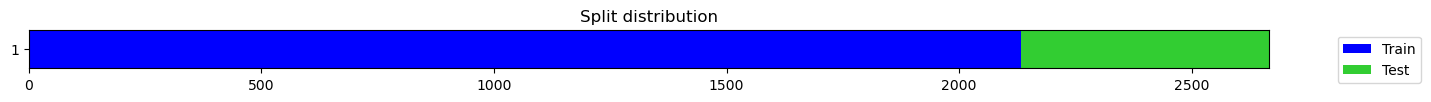

((#2132) [0,1,2,3,4,5,6,7,8,9...],
 (#533) [2132,2133,2134,2135,2136,2137,2138,2139,2140,2141...])

In [13]:
assert config.analysis_mode in ['offline','online'], 'Invalid analysis mode'

X = X_train

if config.analysis_mode == 'online':
    splits = TimeSplitter(valid_size=0.2, show_plot=True)(X)
    
elif config.analysis_mode == 'offline':
    splits = get_splits(np.arange(len(X)), valid_size=config.valid_size)
    
splits

## MVP - Encoder training
> Train MVP with optional adaptable window sizes, to allow for inference with different
window sizes, to provide an easier exploration of the embedding space through different
ways of sliding the data.

### Set callback list

In [14]:
cbs = L(WandbCallback(log_preds=False)) if config.use_wandb else L()

### Set transformations

In [15]:
tfms = [ToFloat(), None]
batch_tfms = [TSStandardize(by_sample=config.norm_by_sample, 
               use_single_batch=config.norm_use_single_batch)]

### Get data loaders

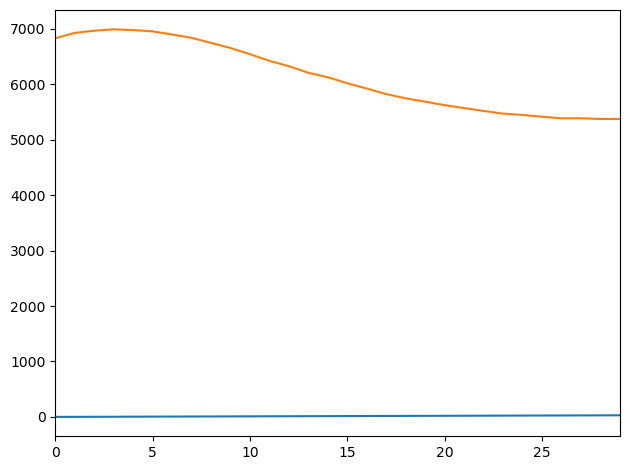

In [16]:
dls = get_ts_dls(X, splits=splits, tfms=tfms, bs=config.batch_size, batch_tfms=batch_tfms)
dls.show_at(0)

### Build MVP TS Learner

In [17]:
sgc = ShowGraphCallback2()
learn = ts_learner(dls, InceptionTimePlus, 
                   cbs= cbs + sgc + MVP(
                       r = config.r, 
                        window_size=config.mvp_ws, 
                        future_mask = config.mask_future, 
                        target_dir='./models', 
                        sync = config.mask_sync, 
                        stateful = config.mask_stateful,
                        fname=f'encoder_MVP'
                    ), y_range=[X.min(), X.max()])

### Example mask

#### Create mask

In [18]:
if config.mask_future:
    example_mask = create_future_mask(torch.from_numpy(X[0]), config.r, sync=config.mask_sync)
else:
    example_mask = create_subsequence_mask(torch.from_numpy(X[0]), config.r, stateful=config.mask_stateful, sync=config.mask_sync)

#### Show mask

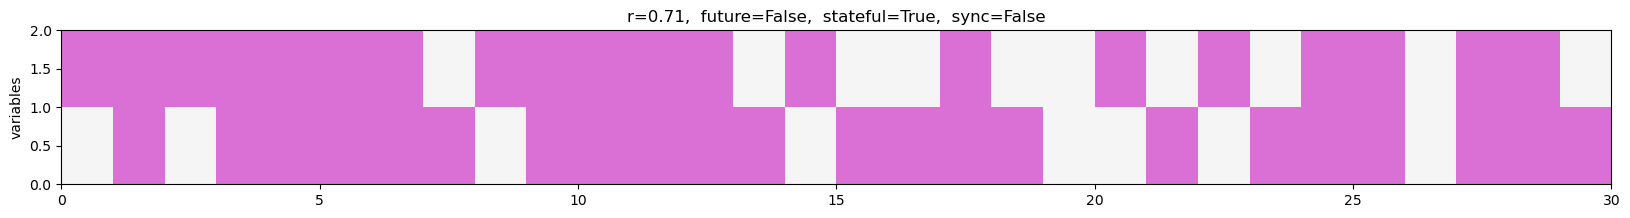

In [19]:
fig, ax = plt.subplots(figsize=(20, 2))
plt.pcolormesh(example_mask[0], cmap=colors.ListedColormap(['whitesmoke', 'orchid']))
plt.title(f'r={config.r},  future={config.mask_future},  stateful={config.mask_stateful},  sync={config.mask_sync}')
ax.set_ylabel('variables')
plt.show()

 ## Check window size configuration

### Check config attributes

In [20]:
expected_window_size = config.mvp_ws
print("w", config.w, "mvp_ws", config.mvp_ws)
print("expected ", expected_window_size)


w 30 mvp_ws [15, 30]
expected  [15, 30]


### Check obtained attributes

In [21]:
mvp_cb = learn.cbs.filter(lambda cb: isinstance(cb, MVP))[0]  # Encuentra el callback MVP
obtained_window_size=mvp_cb.window_size
print("obtained ", obtained_window_size)

obtained  [15, 30]


In [22]:
if (expected_window_size != obtained_window_size):
    raise ValueError("Obtained window_size for MVP training different from expected window size. Check size, ws1 & ws2 parameters in '02b-encoder_MVP.yaml'")
else: 
    print("Obtained window size tuple is the expected one. Continue!")

Obtained window size tuple is the expected one. Continue!


#### Check w1 < w2 for MVP random window size selection

In [23]:
if (obtained_window_size[1] < obtained_window_size[0]):
    raise ValueError("Ws2 must be greater than Ws1 as they are the maximun and minimum window size respectively. Please ensure w2 > w1")
else: 
    w_sizes = np.random.randint(obtained_window_size)
    print(w_sizes)

[ 9 19]


#### Check self.x.shape[-1] for np.random.randint(0, self.x.shape[-1] - ws) MMVP calculus

In [24]:
#Get data batch
x = next(iter(dls.train))
print("x", x)
x_data=x[0]
print("Data shape: " + str( x_data.shape))
time_serie_len = x_data.shape[-1]
print("Time serie len: " + str( time_serie_len))
#Just in case
for ws in w_sizes:
    diff = time_serie_len - ws
    print("diff time serie len - ws", diff)
    result = np.random.randint(0, diff)
    print("ws ", ws, "diff", diff, "result",  result)

x (TSTensor(samples:1024, vars:2, len:30, device=cuda:0, dtype=torch.float32),)
Data shape: torch.Size([1024, 2, 30])
Time serie len: 30
diff time serie len - ws 21
ws  9 diff 21 result 7
diff time serie len - ws 11
ws  19 diff 11 result 4


### Train the model

epoch     train_loss  valid_loss  time           
0         1.202412    4.714671    00:00          


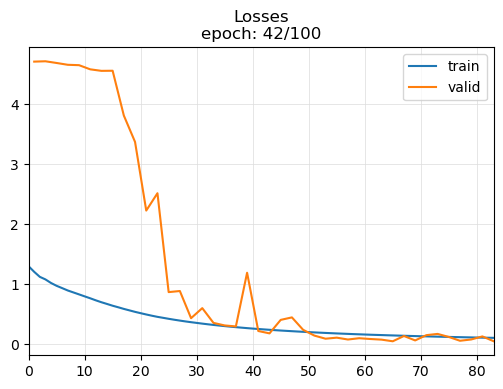

1         1.076044    4.720397    00:00          
2         0.968872    4.691896    00:00          
3         0.890608    4.661612    00:00          
4         0.825796    4.655394    00:00          
5         0.760564    4.585845    00:00          
6         0.694470    4.560407    00:00          
7         0.636306    4.562260    00:00          
8         0.583160    3.813766    00:00          
9         0.533873    3.373086    00:00           
10        0.490059    2.226175    00:00           
11        0.450484    2.515972    00:00           
12        0.417855    0.863840    00:00           
13        0.387858    0.882028    00:00           
14        0.361165    0.428134    00:00           
15        0.337321    0.595948    00:00           
16        0.315410    0.349581    00:00           
17        0.295793    0.306871    00:00           
18        0.278138    0.290244    00:00           
19        0.262031    1.187318    00:00           
20        0.247440    0.213909    00:00

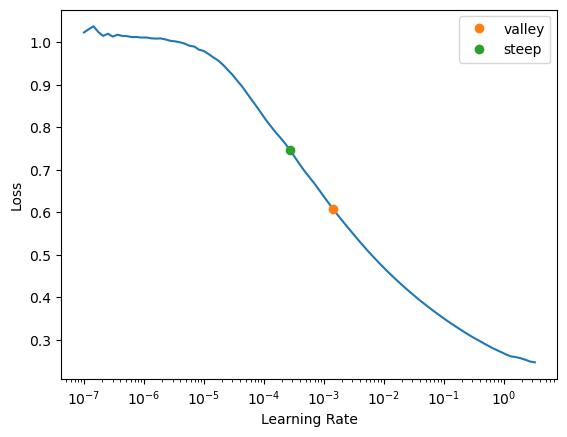

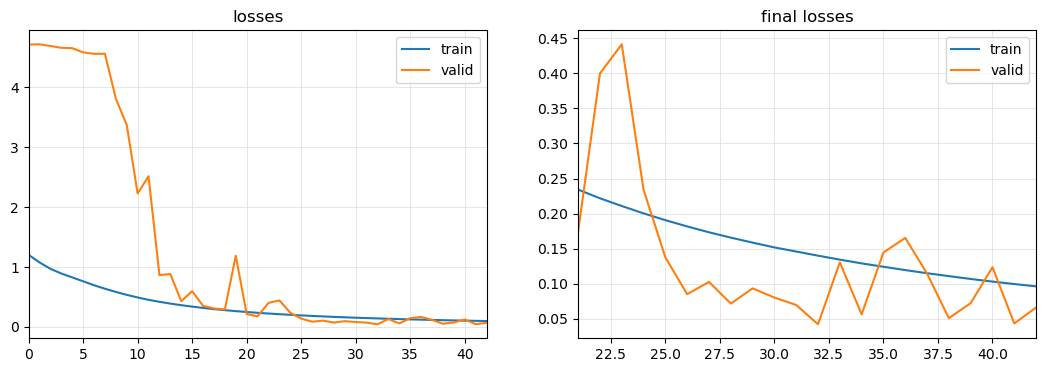

In [25]:
lr_valley, lr_steep = learn.lr_find(suggest_funcs=(valley, steep))
learn.fit_one_cycle(n_epoch=config.epochs, lr_max=lr_valley,  cbs=[EarlyStoppingCallback(monitor='valid_loss', min_delta=0.000001, patience=10)])

#### Validate the model

In [26]:
learn.validate()

not enough values to plot a chart


(#1) [7.644510746002197]

## Visualize predictions

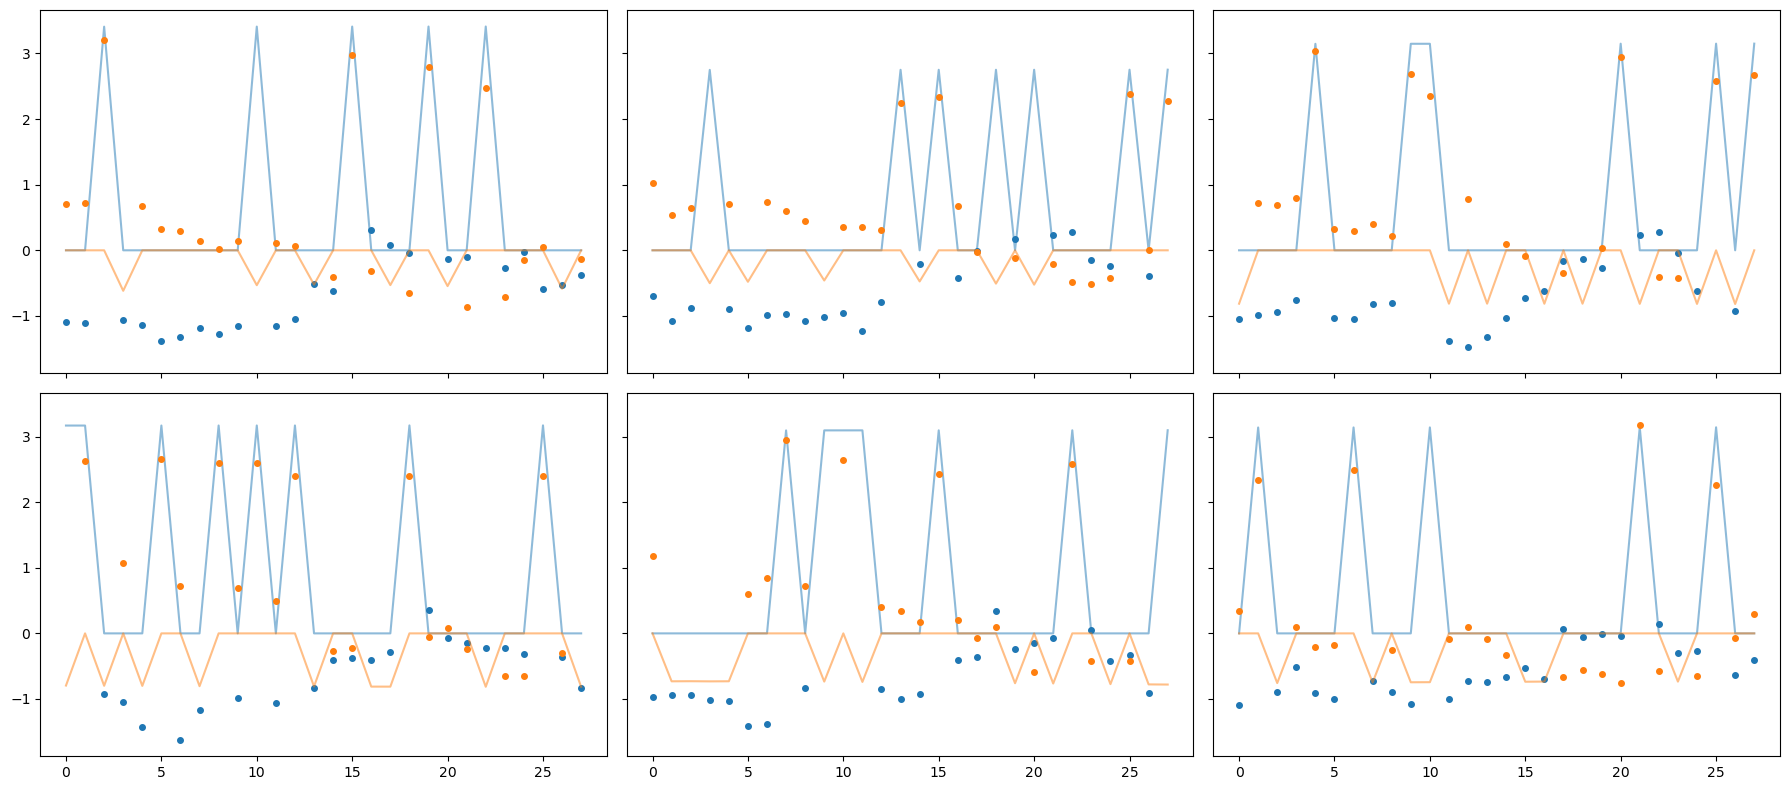

In [27]:
learn.MVP.show_preds(sharey=True, nrows=2) # error with nwors=1 or ncols=1

## Save artifact to W&B
> Remove extra information and saving the learner object as an weight and biases artifact

In [28]:
# Remove the ShowGraphCallback2 callback to avoid errors in the frontend (TODO)
learn.remove_cb(sgc)

In [29]:
# Log the learner without the datasets
aux_learn = learn.export_and_get()
if config.use_wandb: 
    run.log_artifact(
        ReferenceArtifact(
            aux_learn, 
            f'mvp', 
            type='learner', 
            metadata=dict(run.config)
        ), 
        aliases=config.alias
    )

## Close W&B

In [30]:
run.finish()

epoch,43
eps_0,1e-05
eps_1,1e-05
lr_0,0.00126
lr_1,0.00126
mom_0,0.86284
mom_1,0.86284
raw_loss,0.03239
sqr_mom_0,0.99
sqr_mom_1,0.99
train_loss,0.09636
